In [1]:
#Это решение задачи по предсказанию цен домов в калифорнии(Линейная регрессия)
#В качестве критерия оценки будет использован корень из среднеквадратичной ошибки

In [3]:
from sklearn import tree
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.special as sc
import scipy.misc
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
housing=pd.read_csv('housing.csv')

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


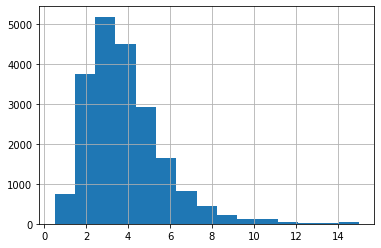

In [5]:
housing.median_income.hist(bins=15)

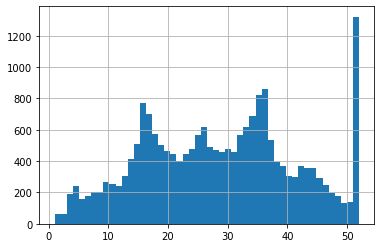

In [10]:
housing.housing_median_age.hist(bins=50)

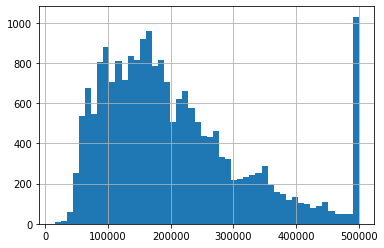

In [18]:
housing.median_house_value.hist(bins=50)

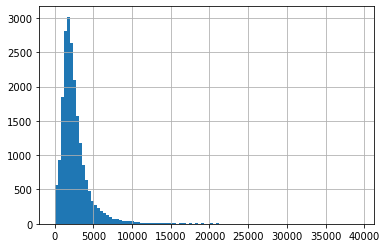

In [17]:
housing.total_rooms.hist(bins=100)

In [ ]:
# Некоторые характеристики имеют медленно убывающие хвосты
# Атрибуты имеют очень разные масштабы
# Атрибуты среднего возраста домов(housing_median_age) и средней стоимости домов(median_house_value),
# явно были ограничены, что может плохо повлиять на нашу модель

In [19]:
housing['income_cat']=np.ceil(housing.median_income/1.5)
housing['income_cat'].where(housing['median_income']<5,5,inplace=True)

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [22]:
#Данные будут разбиты пропорционально значениям в категории income_cat
for train_index, test_index in split.split(housing, housing['income_cat']):
    start_train_set=housing.loc[train_index]
    start_test_set=housing.loc[test_index]

In [12]:
start_train_set.drop('income_cat',axis=1,inplace=True)

In [13]:
start_test_set.drop('income_cat',axis=1,inplace=True)

In [25]:
housing=start_train_set.copy()

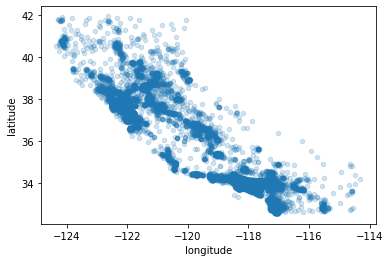

In [26]:
housing.plot(kind='scatter',x='longitude',y='latitude', alpha=0.2)

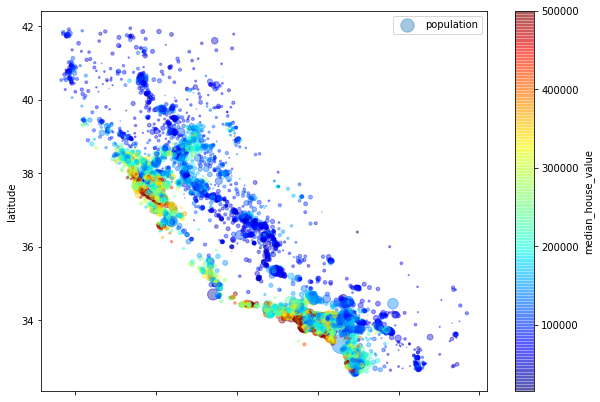

In [27]:
housing.plot(kind='scatter',x='longitude',y='latitude', alpha=0.4,\
            s=housing['population']/100,label='population',\
            figsize=(10,7), c='median_house_value',\
            cmap=plt.get_cmap('jet'),colorbar=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027333B29488>,
      dtype=object)

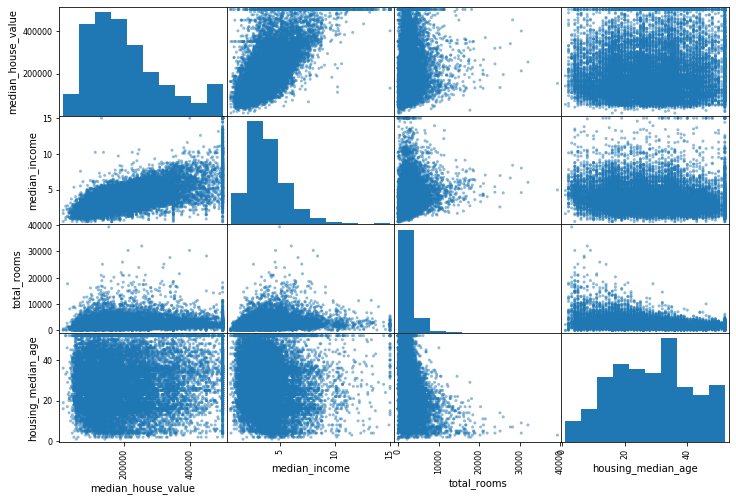

In [28]:
from pandas.plotting import scatter_matrix
attributes=["median_house_value" , "median_income" , "total_rooms",\
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

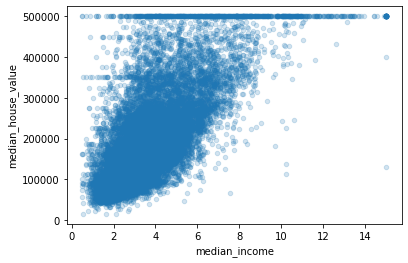

In [30]:
# На этом графике видно предел напротив значения 50000, так же горизонтальные
# линии напротив 450000, 350000, возможно стоит удалить эти данные, для 
# проверки их влияние на модель
housing.plot(kind='scatter',x='median_income',y='median_house_value', alpha=0.2)

In [29]:
# Эксперементирование с комбинированием атрибутов
housing["bedrooms_per_room"] =\
housing["total_bedrooms"]/housing["total_rooms"]
housing ["rooms_per_household"] =\
housing ["total_rooms"]/housing["households"]

In [31]:
# Наш новый признак bedrooms_per_room (кол-во спален на кол-во комнат)
# имеет хорошую корреляцию с целевым атрибутом
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687752
income_cat             0.620944
rooms_per_household    0.145300
total_rooms            0.136422
housing_median_age     0.106985
households             0.066340
total_bedrooms         0.050081
population            -0.024622
longitude             -0.047586
latitude              -0.142814
bedrooms_per_room     -0.258861
Name: median_house_value, dtype: float64

In [ ]:
# Подготовка данных для ML

In [34]:
housing=start_train_set.drop('median_house_value',axis=1)

In [35]:
housing_labels=start_train_set['median_house_value'].copy()

In [36]:
#Замена пустых знач медианами
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
housing_num=housing.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)
imputer.statistics_
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X, columns=housing_num.columns)

In [40]:
#Разбиение категорий на значения 0,1,2 
housing_cat=housing['ocean_proximity']
housing_cat_encoded, housing_categories=housing_cat.factorize()

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int64)

In [41]:
#Разбинеие категориального признака на
#матрицу 0 и 1 
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))


In [43]:
# Создание своего трансформатора который добавляет скомбинированые атрибуты
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [45]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)


In [47]:
# Cоздание конвеера для трансфарматоров
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [48]:
# Трансфрматор для выбора нужных атрибутов
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): 
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [52]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [53]:
# Объеденение конвееров
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [54]:
housing_prepared=full_pipeline.fit_transform(housing)

In [55]:
housing_prepared.shape

(16512, 17)

In [ ]:
# Обучение моделей

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
lin_reg = LinearRegression()

In [58]:
lin_reg.fit(housing_prepared,housing_labels)


LinearRegression()

In [59]:
some_data=housing_prepared[:5]
some_labels=housing_labels.iloc[:5]


In [60]:
print('Прогнозы',lin_reg.predict(some_data))
print('метки',list(some_labels))

Прогнозы [393856. 411392. 226816.  98560. 287232.]
метки [500001.0, 500001.0, 174200.0, 91400.0, 434000.0]


In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
housing_predictions=lin_reg.predict(housing_prepared)
lin_mse=mean_squared_error(housing_labels,housing_predictions)
lin_rmse=np.sqrt(lin_mse)

In [63]:
lin_rmse

68338.20305462193

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [73]:
tree_reg=DecisionTreeRegressor()

In [75]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [76]:
tree_rmse_scores.mean()

72234.67311212035

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [78]:
forest_reg=RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

RandomForestRegressor()

In [ ]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
tree_rmse_scores.mean()

In [80]:
from sklearn.neighbors import KNeighborsRegressor

In [81]:
neighbor=KNeighborsRegressor(n_neighbors=15)

In [82]:
scores = cross_val_score(neighbor, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [83]:
tree_rmse_scores

array([59943.4681299 , 57701.72224189, 60288.94786685, 63210.02148042,
       63222.48713103, 65370.45154954, 59087.69275713, 61185.15224396,
       63535.96885497, 64184.32156441])

In [84]:
# Используем решетчатый поиск для точной настройки модели
from sklearn.model_selection import GridSearchCV

In [85]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [130]:
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
       scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [183]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [184]:
best_model=grid_search.best_estimator_
feature_importances = grid_search.best_estimator_.feature_importances_

In [157]:
scores = cross_val_score(best_model, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [158]:
tree_rmse_scores

array([49814.62642653, 45870.31028804, 47712.0130442 , 51893.78742083,
       51230.92672695, 54087.68626803, 48907.46011751, 48130.60376706,
       52358.93398378, 51971.00704543])

In [159]:
X_test=start_test_set.drop('median_house_value',axis=1)
y_test=start_test_set['median_house_value'].copy()

In [168]:
X_test_prepared=full_pipeline.transform(X_test)

In [166]:
final_predictions=best_model.predict(X_test_prepared)

In [167]:
final_mse=mean_squared_error(y_test, final_predictions)
final_rmse=np.sqrt(final_mse)
final_rmse

59962.58819392542

In [186]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
attributes = num_attribs + extra_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3611117937300803, 'median_income'),
 (0.10621549214881919, 'pop_per_hhold'),
 (0.07608033026553325, 'longitude'),
 (0.06595804683238471, 'latitude'),
 (0.060962002604011696, 'bedrooms_per_room'),
 (0.05789110894637073, 'rooms_per_hhold'),
 (0.03975077562795959, 'housing_median_age'),
 (0.01524061160401232, 'population'),
 (0.014850492707640158, 'total_rooms'),
 (0.01481144810953673, 'total_bedrooms'),
 (0.013668683707823474, 'households')]

In [ ]:
# Итоговая модель имеет среднюю ошибку 59962, что достаточно неплохо